## Notebook pour voir les résultats des DMPs : Pour GESRes Jester dataset

In [5]:
from video import Video
import visualize
from utils import landmarks_2_table
import mediapipe as mp
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import os

2025-12-07 20:27:25.787516: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 20:27:25.788296: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 20:27:25.791383: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 20:27:25.800385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765106845.816138  569200 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765106845.82

In [6]:
import numpy as np

class DMPVector:
    def __init__(self, n_basis: int = 20):
        self.n_basis = n_basis # number of gaussians
        self.centers = None
        self.widths = None
        self.W = None       # (n_basis, D)
        self.y0 = None      # (D,)
        self.g = None       # (D,)
        self.T_train = None

    def _basis_functions(self, T: int):
        t = np.linspace(0.0, 1.0, T)
        self.centers = np.linspace(0.0, 1.0, self.n_basis)
        self.widths = np.ones(self.n_basis) * (self.n_basis ** 2)
        psi = np.exp(-self.widths * (t[:, None] - self.centers[None, :])**2)
        return psi, t

    def fit(self, Y: np.ndarray):
        T, D = Y.shape
        self.T_train = T
        self.y0 = Y[0].copy()
        self.g  = Y[-1].copy()

        psi, t = self._basis_functions(T)   # (T, n_basis)
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))   # (T, D)
        F_target = Y - Y_lin                                # (T, D)

        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                           # (T, n_basis)

        self.W, _, _, _ = np.linalg.lstsq(psi_norm, F_target, rcond=None)

    def fit_multi(self, Y_batch: np.ndarray):
        N, T, D = Y_batch.shape
        self.T_train = T

        psi, t = self._basis_functions(T)           # (T, n_basis)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                    # (T, n_basis)

        F_list = []
        y0_all = []
        g_all  = []

        for i in range(N):
            Y = Y_batch[i]
            y0_i = Y[0].copy()
            g_i  = Y[-1].copy()

            y0_all.append(y0_i)
            g_all.append(g_i)

            Y_lin_i = y0_i + np.outer(t, (g_i - y0_i))   # (T, D)
            F_i     = Y - Y_lin_i                        # (T, D)
            F_list.append(F_i)

        F_all = np.concatenate(F_list, axis=0)           # (N*T, D)
        Psi_big = np.tile(psi_norm, (N, 1))              # (N*T, n_basis)

        self.W, _, _, _ = np.linalg.lstsq(Psi_big, F_all, rcond=None)

        self.y0 = np.mean(np.stack(y0_all, axis=0), axis=0)
        self.g  = np.mean(np.stack(g_all,  axis=0), axis=0)

    def rollout(self, T: int = None, amplitude_scale: float = 1.0) -> np.ndarray:
        if T is None:
            T = self.T_train

        psi, t = self._basis_functions(T)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum

        F = psi_norm @ self.W * amplitude_scale
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))
        Y = Y_lin + F
        return Y


In [7]:
KEYPOINTS = [0, 2, 5] + list(range(7, 25)) # keypoints à utiliser



In [8]:
def vec_to_skeleton(Y_vec: np.ndarray, n_points=21) -> np.ndarray:
    """
    Convertit un vecteur DMP en squelette 2D avec n_points articulations.
    Y_vec : (T, 2*n_points)
    -> (T, n_points, 2)
    """
    T, D = Y_vec.shape
    assert D == 2 * n_points, f"Expected {2*n_points} dims, got {D}"
    return Y_vec.reshape(T, n_points, 2)



In [9]:
def rotate_skeleton_xy(seq: np.ndarray) -> np.ndarray:
    """
    Prend un tableau (T, J, 2) et échange les colonnes x et y.
    Retourne un nouveau tableau (ne modifie pas l'original).
    """
    rotated = seq.copy()
    pts = rotated.copy()
    rotated[:, :, 0] = pts[:, :, 1]  # nouveau x = ancien y
    rotated[:, :, 1] = pts[:, :, 0]  # nouveau y = ancien x
    return rotated



In [20]:
EDGES = [
    # --- tête ---
    (0, 1),   # nose → right eye
    (1, 2),   # right eye → left eye
    (2, 3),   # left eye → right ear
    (2, 4),   # left eye → left ear
    (5, 6),   # mouth R → mouth L

    # --- épaules ---
    (7, 8),   # shoulder R → shoulder L

    # --- bras droit ---
    (7, 9),   # shoulder R → elbow R
    (9, 11),  # elbow R → wrist R
    (11, 13), # wrist R → pinky R
    (11, 15), # wrist R → index R
    (11, 17), # wrist R → thumb R

    # --- bras gauche ---
    (8, 10),  # shoulder L → elbow L
    (10, 12), # elbow L → wrist L
    (12, 14), # wrist L → pinky L
    (12, 16), # wrist L → index L
    (12, 18), # wrist L → thumb L

    # --- hanches ---
    (19, 20), # hip R → hip L
    (8, 20),
    (7, 19),
]

def plot_stickman_frame2(ax, norm_seq, frame_idx: int):
    pts = norm_seq[frame_idx]          # (33, 2)
    visible = ~np.isnan(pts).any(axis=1)

    ax.cla()   # efface le contenu des axes

    # segments
    for i, j in EDGES:
        if i < pts.shape[0] and j < pts.shape[0]:
            if visible[i] and visible[j]:
                x_vals = [pts[i, 0], pts[j, 0]]
                y_vals = [pts[i, 1], pts[j, 1]]
                ax.plot(x_vals, y_vals, "-")

    # points visibles
    x_vis = pts[visible, 0]
    y_vis = pts[visible, 1]
    ax.scatter(x_vis, y_vis, c="red")

    # indices
    for idx in np.where(visible)[0]:
        x, y = pts[idx]
        ax.text(x, y, str(idx), fontsize=7)

    ax.set_title(f"Stickman (frame {frame_idx})")
    ax.axis("equal")
    ax.grid(True)

In [11]:
import joblib

def plot_stickman(label, T=50, joblib_dir="datasets_2D"):
    """
    Affiche un stickman 2D animé pour un label donné.
    Le DMP est chargé depuis datasets/<label>.joblib.
    """

    # --- Charger le joblib ---
    joblib_path = os.path.join(joblib_dir, f"{label}.joblib")
    if not os.path.exists(joblib_path):
        raise FileNotFoundError(f"❌ Aucun modèle .joblib trouvé pour '{label}'")

    data = joblib.load(joblib_path)
    dmp = data["dmp"]

    # Le nombre de points dépend du format de X (2D → diviser par 2)
    n_points = data["X"].shape[2] // 2

    # --- Générer la trajectoire DMP ---
    Y = dmp.rollout(T=T)                          # (T, 2*n_points)
    skel_seq = vec_to_skeleton(Y, n_points)       # (T, n_points, 2)

    # --- Animation ---
    fig, ax = plt.subplots(figsize=(6, 6))

    for i in range(T):
        # appliquer la rotation XY si tu l'utilises
        skel_rot = rotate_skeleton_xy(skel_seq)

        # afficher la frame i
        plot_stickman_frame2(ax, skel_rot, i)

        ax.set_title(f"{label} – frame {i+1}/{T}")
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)

        clear_output(wait=True)
        display(fig)
        plt.pause(0.05)

    plt.close(fig)


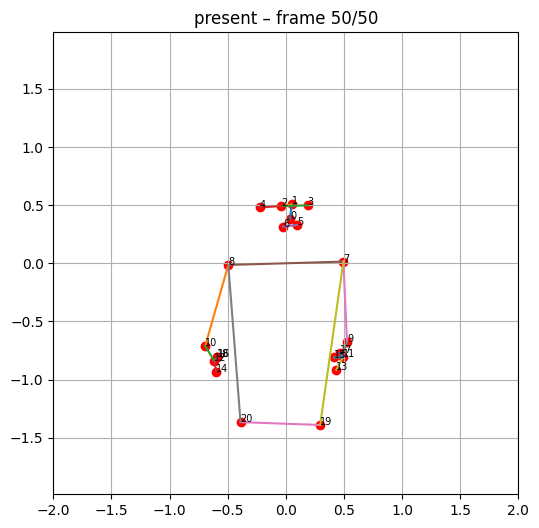

In [30]:
# plot_stickman("one")
# plot_stickman("finger")
# plot_stickman("cup")
# plot_stickman("knock")
# plot_stickman("clasp")
# plot_stickman("hold")
# plot_stickman("punch")
# plot_stickman("point")
plot_stickman("present")
# plot_stickman("show")
# plot_stickman("soft")
# plot_stickman("present")
# plot_stickman("hand")